In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.ToTensor()

train_data = datasets.CIFAR10(root='C:/Works/Personal/repo/DatasetFolder/CIFAR-10Dataset', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='C:/Works/Personal/repo/DatasetFolder/CIFAR-10Dataset', train=False, download=True, transform=transform)

Failed download. Trying https -> http instead. Downloading http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to C:/Works/Personal/repo/DatasetFolder/CIFAR-10Dataset\cifar-10-python.tar.gz


100.0%

Files already downloaded and verified


In [3]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: C:/Works/Personal/repo/DatasetFolder/CIFAR-10Dataset
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [4]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: C:/Works/Personal/repo/DatasetFolder/CIFAR-10Dataset
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [5]:
torch.manual_seed(101)  # for reproducible results

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [6]:
train_loader.batch_size

10

In [7]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

In [8]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

#grabing the first batch of 10 images
for images,labels in train_loader: 
    break

In [9]:
labels

tensor([3, 2, 0, 4, 9, 5, 1, 2, 4, 8])

Label: [    3     2     0     4     9     5     1     2     4     8]
Class:    cat  bird plane  deer truck   dog   car  bird  deer  ship


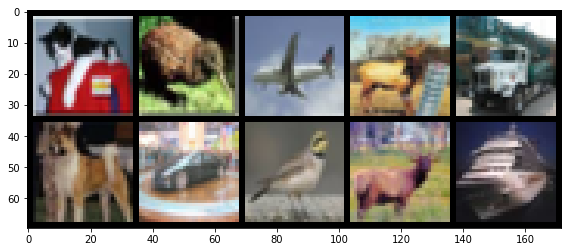

In [10]:
#Printing the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

#Printing the images
im = make_grid(images, nrow=5)  # the default nrow is 8
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [12]:
#understanding the images dimensions
images[0].shape
#(((32−2)/2)−2)/2=6.5  which rounds down to 6 pixels per side.

torch.Size([3, 32, 32])

In [13]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)  # changed from (1, 6, 5, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(6*6*16, 120)   # changed from (4*4*16) to fit 32x32 images with 3x3 filters
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [14]:
torch.manual_seed(101)
model = ConvolutionalNetwork()

In [15]:
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [21]:
params = [p.numel() for p in model.parameters() if p.requires_grad]
for param in model.parameters():
    print(param.numel())
print(f'______\n{sum(params):>6}')

162
6
864
16
69120
120
10080
84
840
10
______
 81302


In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [39]:
import time
start_time = time.time()

epochs = 50
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    #running the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        #applying the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        #tallying the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        #updating parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #printing interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    #running the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            #applying the model
            y_val = model(X_test)

            #tallying the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed 

epoch:  0  batch: 1000 [ 10000/50000]  loss: 0.42411876  accuracy:  70.530%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 0.74089921  accuracy:  70.110%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 1.00637591  accuracy:  70.100%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 0.47638693  accuracy:  69.922%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 1.30444860  accuracy:  69.726%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 0.56745225  accuracy:  72.130%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 1.05365634  accuracy:  71.975%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 0.53058392  accuracy:  71.560%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 1.39380515  accuracy:  71.180%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 0.87825048  accuracy:  70.680%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 0.38434005  accuracy:  72.920%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 0.55450851  accuracy:  72.645%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 0.49920711  accuracy:  72.163%
epoch:  2  b

epoch: 21  batch: 4000 [ 40000/50000]  loss: 0.31654882  accuracy:  81.860%
epoch: 21  batch: 5000 [ 50000/50000]  loss: 0.51443213  accuracy:  81.594%
epoch: 22  batch: 1000 [ 10000/50000]  loss: 0.42713481  accuracy:  84.160%
epoch: 22  batch: 2000 [ 20000/50000]  loss: 0.30544072  accuracy:  83.300%
epoch: 22  batch: 3000 [ 30000/50000]  loss: 0.52920568  accuracy:  82.697%
epoch: 22  batch: 4000 [ 40000/50000]  loss: 0.83103102  accuracy:  82.100%
epoch: 22  batch: 5000 [ 50000/50000]  loss: 0.99732828  accuracy:  81.770%
epoch: 23  batch: 1000 [ 10000/50000]  loss: 0.33907911  accuracy:  84.400%
epoch: 23  batch: 2000 [ 20000/50000]  loss: 0.72274518  accuracy:  82.935%
epoch: 23  batch: 3000 [ 30000/50000]  loss: 0.11034951  accuracy:  82.447%
epoch: 23  batch: 4000 [ 40000/50000]  loss: 0.38000813  accuracy:  82.135%
epoch: 23  batch: 5000 [ 50000/50000]  loss: 0.13656184  accuracy:  81.940%
epoch: 24  batch: 1000 [ 10000/50000]  loss: 0.24150746  accuracy:  84.340%
epoch: 24  b

epoch: 43  batch: 2000 [ 20000/50000]  loss: 0.40167969  accuracy:  87.860%
epoch: 43  batch: 3000 [ 30000/50000]  loss: 0.14691100  accuracy:  87.153%
epoch: 43  batch: 4000 [ 40000/50000]  loss: 0.54936594  accuracy:  86.825%
epoch: 43  batch: 5000 [ 50000/50000]  loss: 0.62048471  accuracy:  86.432%
epoch: 44  batch: 1000 [ 10000/50000]  loss: 0.05335686  accuracy:  88.820%
epoch: 44  batch: 2000 [ 20000/50000]  loss: 0.40899768  accuracy:  88.265%
epoch: 44  batch: 3000 [ 30000/50000]  loss: 0.01954250  accuracy:  87.700%
epoch: 44  batch: 4000 [ 40000/50000]  loss: 0.24248192  accuracy:  87.270%
epoch: 44  batch: 5000 [ 50000/50000]  loss: 0.19278371  accuracy:  86.962%
epoch: 45  batch: 1000 [ 10000/50000]  loss: 0.17858455  accuracy:  89.420%
epoch: 45  batch: 2000 [ 20000/50000]  loss: 0.49691099  accuracy:  88.125%
epoch: 45  batch: 3000 [ 30000/50000]  loss: 0.52424824  accuracy:  87.587%
epoch: 45  batch: 4000 [ 40000/50000]  loss: 0.16489883  accuracy:  87.025%
epoch: 45  b

In [40]:
torch.save(model.state_dict(), 'CIFAR-10Classification.pt')

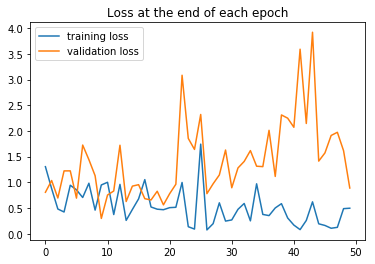

In [41]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

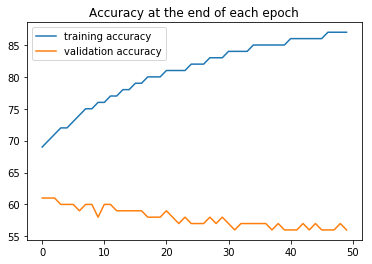

In [42]:
plt.plot([t/500 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [43]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

[tensor(6127), tensor(6112), tensor(6108), tensor(6082), tensor(6062), tensor(6068), tensor(5992), tensor(6043), tensor(6046), tensor(5840), tensor(6055), tensor(6054), tensor(5973), tensor(5908), tensor(5996), tensor(5978), tensor(5985), tensor(5884), tensor(5872), tensor(5874), tensor(5933), tensor(5854), tensor(5780), tensor(5870), tensor(5792), tensor(5790), tensor(5788), tensor(5804), tensor(5784), tensor(5863), tensor(5766), tensor(5647), tensor(5776), tensor(5714), tensor(5717), tensor(5736), tensor(5702), tensor(5653), tensor(5733), tensor(5669), tensor(5678), tensor(5632), tensor(5730), tensor(5658), tensor(5731), tensor(5640), tensor(5648), tensor(5651), tensor(5702), tensor(5626)]

Test accuracy: 56.260%


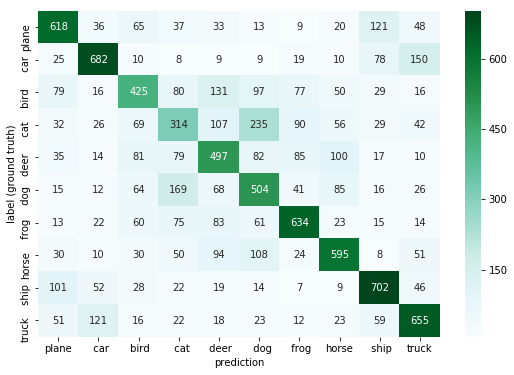

In [44]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

In [45]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

4374

In [32]:
# Display the first 8 index positions
misses[:8]

array([    3,     4,     6,     7,     8,    17,    20,    21],
      dtype=int64)

In [33]:
#setting up an iterator to feed batched rows
r = 8   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Index: [    3     4     6     7     8    17    20    21]
Label: [    0     6     1     6     3     7     7     0]
Class:  plane  frog   car  frog   cat horse horse plane

Guess: [    8     4     2     4     5     3     2     2]
Class:   ship  deer  bird  deer   dog   cat  bird  bird


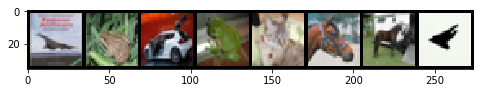

In [34]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

nextrow = next(row)
lbls = y_test.index_select(0,torch.tensor(nextrow)).numpy()
gues = predicted.index_select(0,torch.tensor(nextrow)).numpy()
print("Index:", nextrow)
print("Label:", lbls)
print("Class: ", *np.array([class_names[i] for i in lbls]))
print()
print("Guess:", gues)
print("Class: ", *np.array([class_names[i] for i in gues]))

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(8,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [36]:
# Instantiate the model and load saved parameters
model2 = ConvolutionalNetwork()
model2.load_state_dict(torch.load('CIFAR-10Classification.pt'))
model2.eval()

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [37]:
# Evaluating the saved model against the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model2(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 6105/10000 =  61.050%


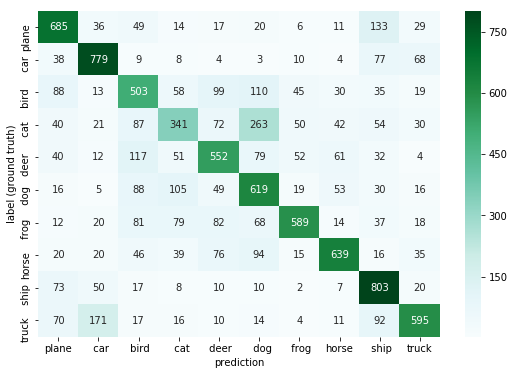

In [38]:
#displaying the confusion matrix as a heatmap
arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();